# Advanced Lane Finding Project

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
*Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

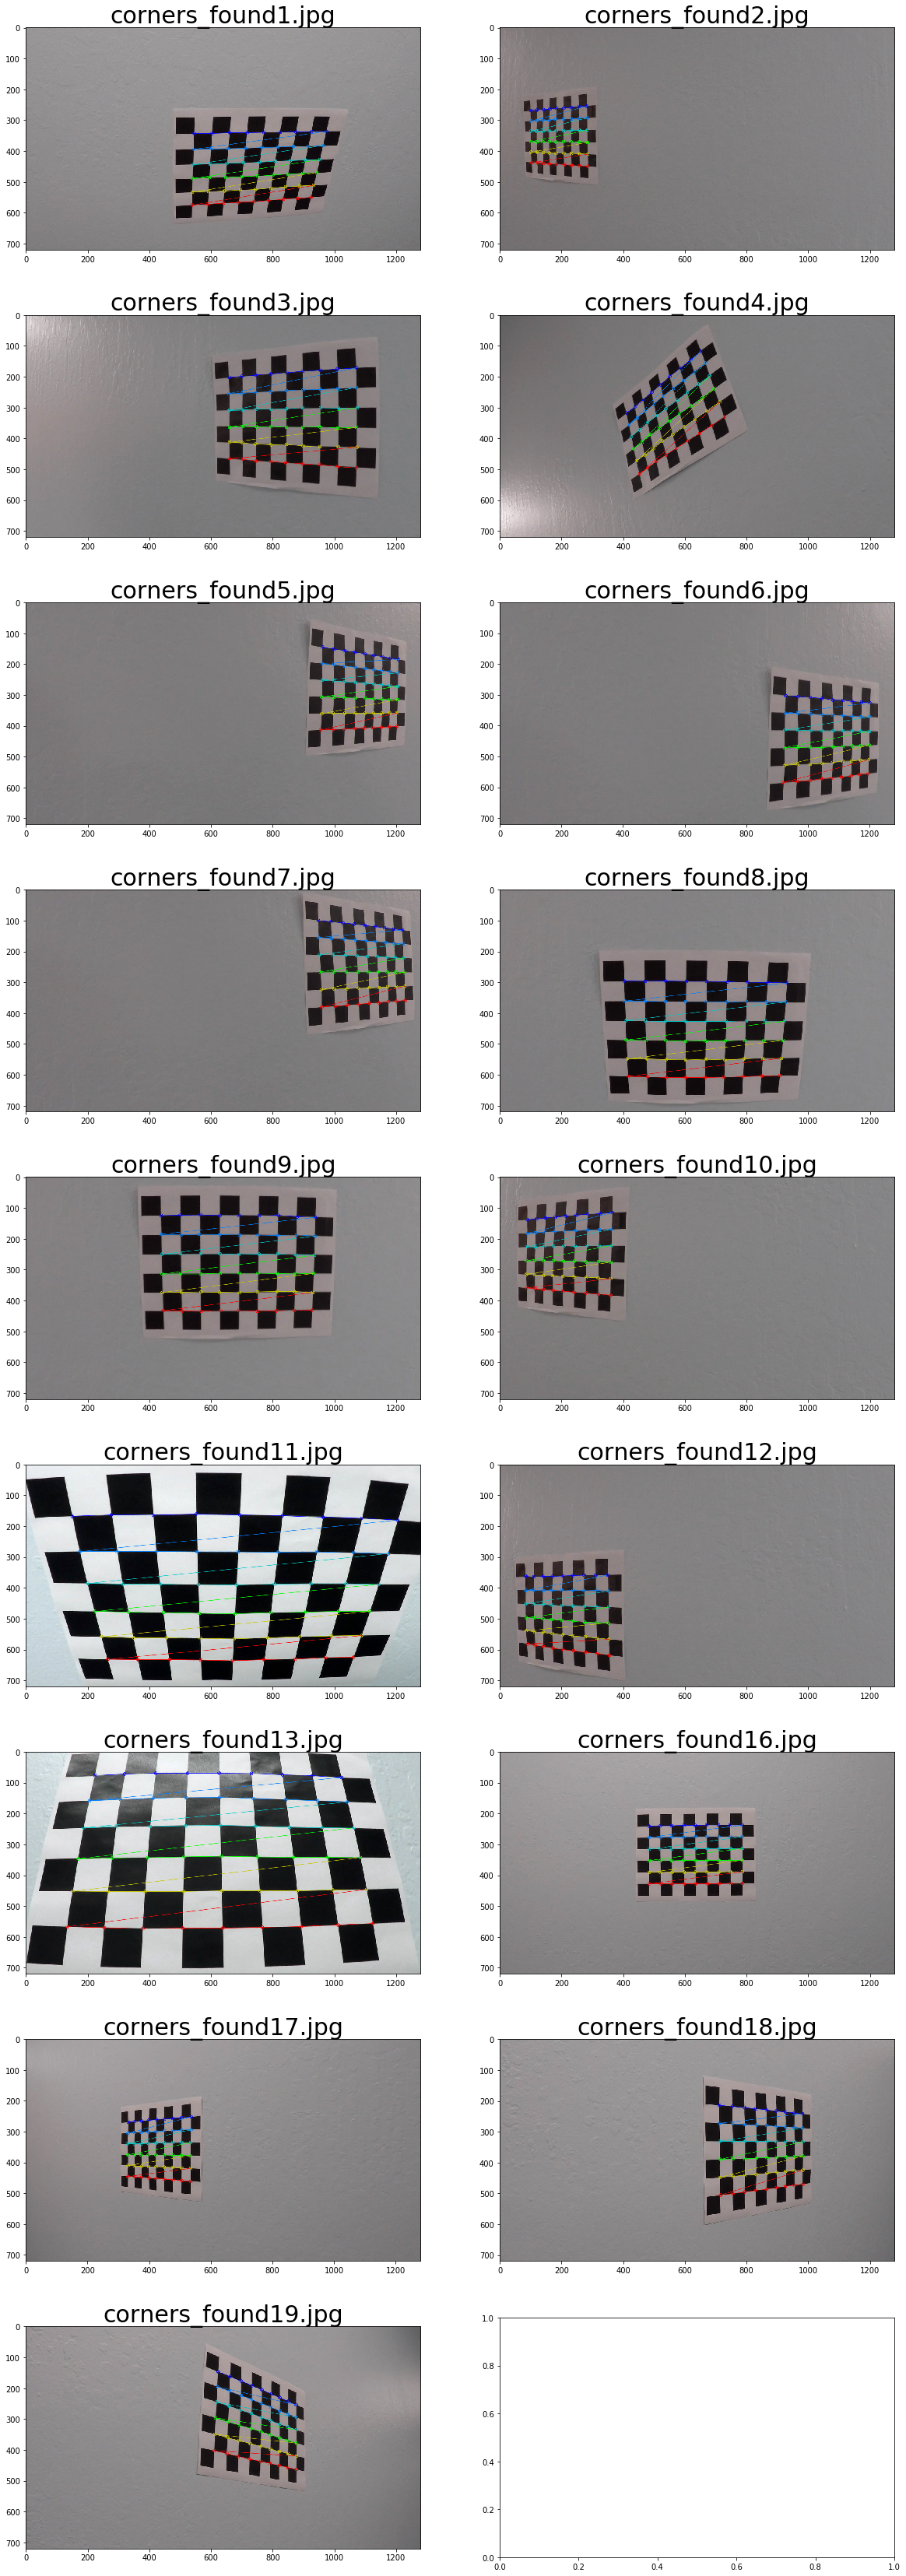

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
x_corner_num = 9
y_corner_num = 6
objp = np.zeros((y_corner_num*x_corner_num,3), np.float32)
objp[:,:2] = np.mgrid[0:x_corner_num, 0:y_corner_num].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
f, axarr = plt.subplots(9, 2, figsize=(20, 60))

counter = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (x_corner_num,y_corner_num), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (x_corner_num,y_corner_num), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        i = counter // 2
        j = counter % 2
        axarr[i, j].imshow(img)
        axarr[i, j].set_title(write_name, fontsize=30)
        counter += 1

### Apply a distortion correction to raw images.

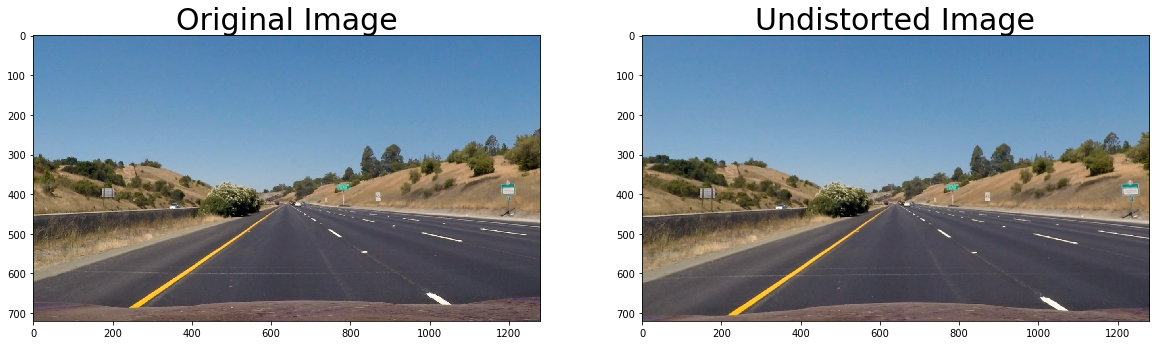

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
#img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort an image
undist_img = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion of a test image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )

### Use color transforms, gradients, etc., to create a thresholded binary image.

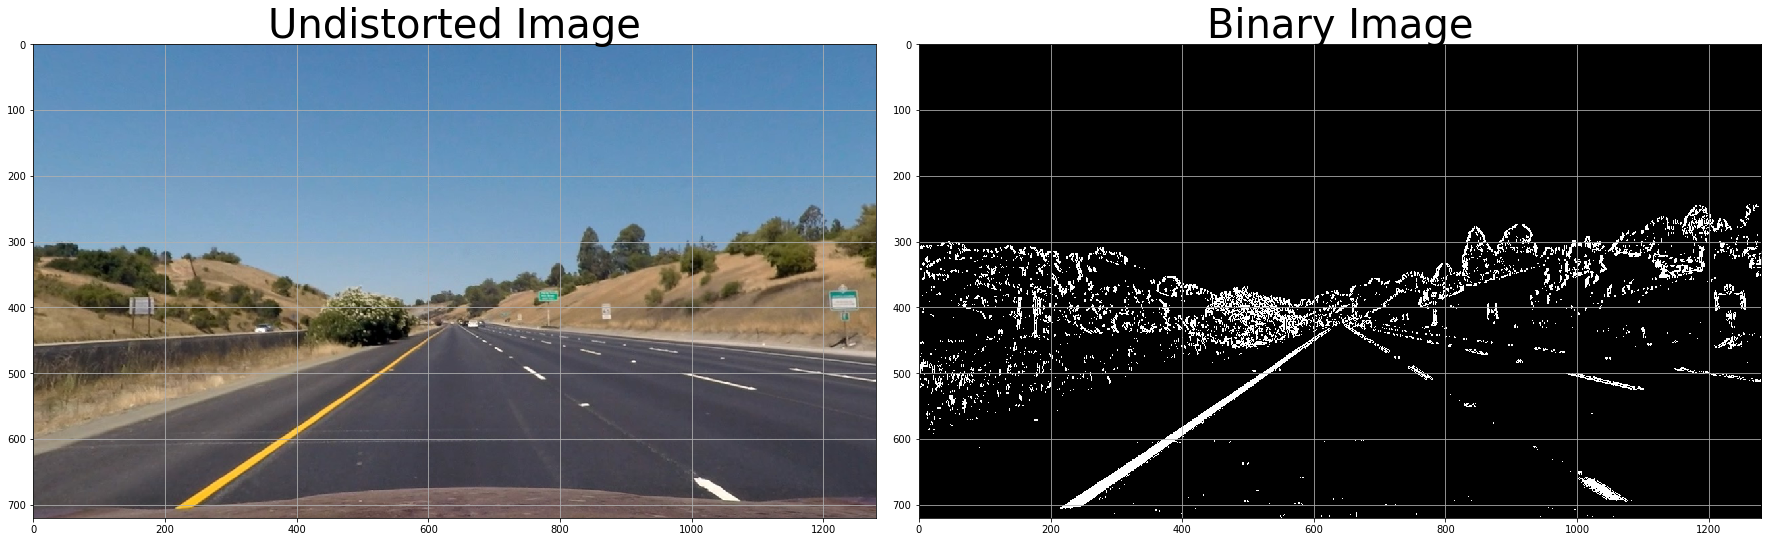

In [3]:
import matplotlib.image as mpimg

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold h channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 180) & (h_channel <= 200)] = 1
    
    # Combine the two binary thresholds
    binary = np.zeros_like(sxbinary)
    binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #binary[(h_binary == 1)] = 1
    binary[(s_binary == 1)] = 1 
    #binary[(sxbinary == 1)] = 1 

    return binary


# Plot the result
binary = pipeline(undist_img)
combined_binary = 255 * np.dstack((binary, binary, binary)).astype('uint8')   

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_img)
ax1.set_title('Undistorted Image', fontsize=40)
ax1.grid()

ax2.imshow(combined_binary)
ax2.set_title('Binary Image', fontsize=40)
ax2.grid()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply a perspective transform to rectify binary image ("birds-eye view").

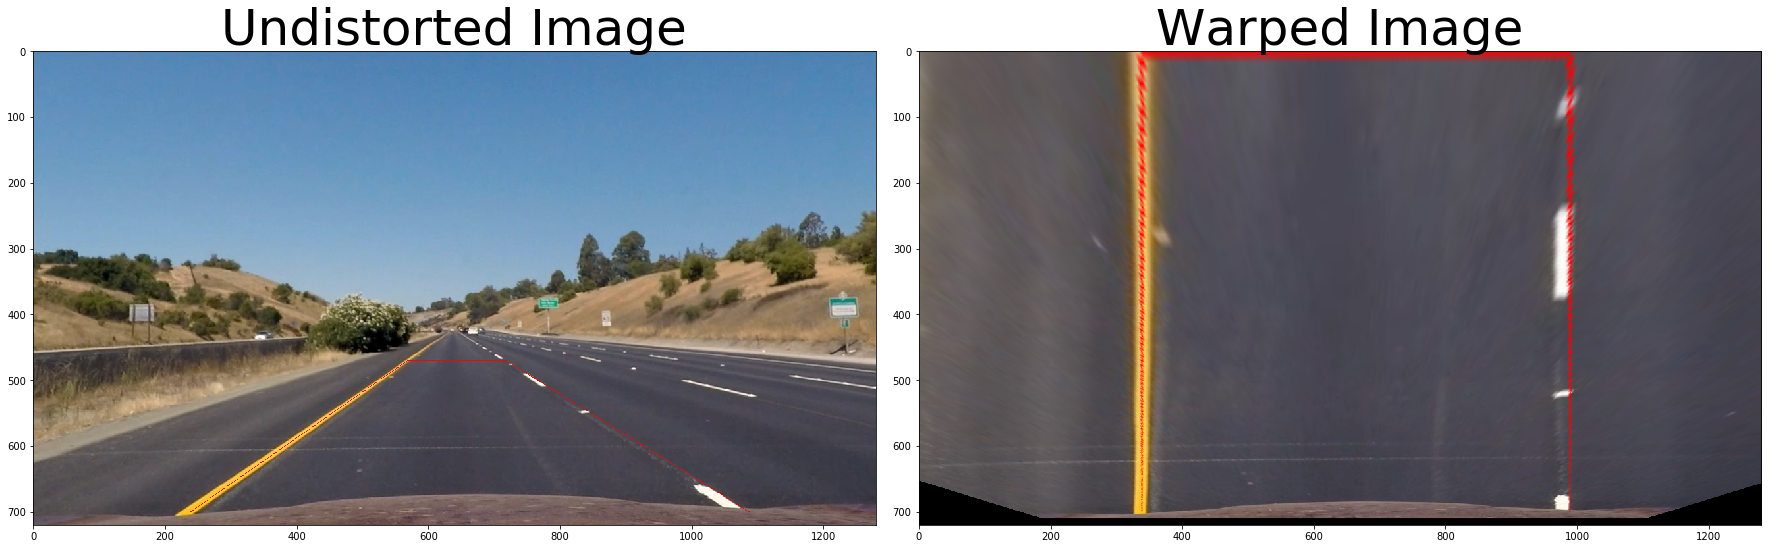

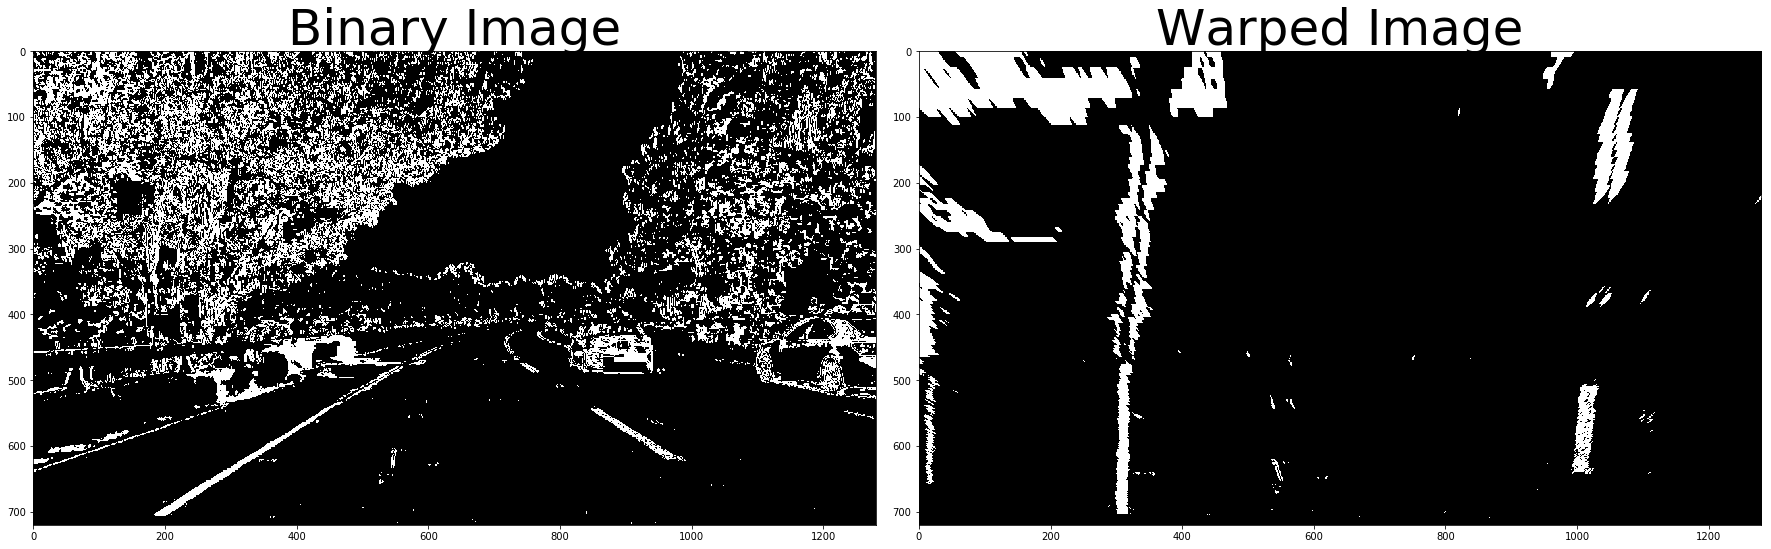

In [4]:
def warp(img, offset=100, src=np.float32([[238, 700], [568, 470], [718, 470], [1088, 700]])):
    dst = np.float32([[src[0,0]+offset, src[0,1]], 
                      [src[0,0]+offset, 0], 
                      [src[3,0]-offset, 0], 
                      [src[3,0]-offset, src[3,1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

# Apply perspective transform on a straight line image to tweak src corners
img = undist_img.copy()

src = np.float32([[238, 700], [568, 470], [718, 470], [1088, 700]])
#src = np.float32([[190,720],[589,457],[698,457],[1145,720]])
cv2.line(img, tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=1)

warped_img, perspective_M, Minv = warp(img)

# Visualize top-down view
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Warp a test image with curve lane to test the warp function
img = mpimg.imread('test_images/test5.jpg')
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
binary = pipeline(undist_img)
binary_warped, perspective_M, Minv = warp(binary)
combined_binary = 255 * np.dstack((binary, binary, binary)).astype('uint8') 
combined_binary_warped = 255 * np.dstack((binary_warped, binary_warped, binary_warped)).astype('uint8') 

# Visualize top-down view
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary)
ax1.set_title('Binary Image', fontsize=50)
ax2.imshow(combined_binary_warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detect lane pixels and fit to find the lane boundary.

Step 1: Implement Sliding Windows and Fit a Polynomial

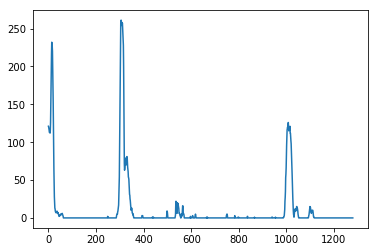

305
1008
window 0 leftx_current 308
window 1 leftx_current 309
window 1 rightx_current 1007
window 2 leftx_current 311
window 2 rightx_current 1013
window 3 leftx_current 315
window 4 leftx_current 326
window 4 rightx_current 1031
window 5 leftx_current 325
window 6 leftx_current 336
window 6 rightx_current 1044
window 7 leftx_current 338
window 7 rightx_current 1056
window 8 leftx_current 316
window 8 rightx_current 1067
[ -8.72026887e-05   1.97180080e-02   3.29549721e+02]
[  8.14715869e-05  -1.59200231e-01   1.07457296e+03]


(720, 0)

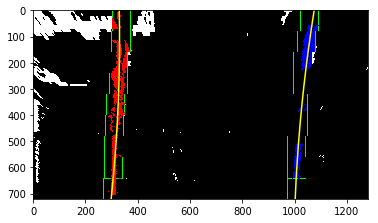

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def sliding_window_fit(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.show()
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print(leftx_base)
    print(rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 35
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    counter = 0
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            print('window {} leftx_current {}'.format(counter, leftx_current))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            print('window {} rightx_current {}'.format(counter, rightx_current))
            
        counter += 1

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return leftx, lefty, rightx, righty, left_fit, right_fit


# Test sliding_window_fit function and visualize test result
out_img = combined_binary_warped.copy()

leftx, lefty, rightx, righty, left_fit, right_fit = sliding_window_fit(binary_warped)

print(left_fit)
print(right_fit)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Step 2: Skip the sliding windows step once you know where the lines are

In [6]:
def margin_fit(binary_warped, left_fit, right_fit, margin=100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return leftx, lefty, rightx, righty, left_fit, right_fit
    

# # Create an image to draw on and an image to show the selection window
# out_img = combined_binary_warped.copy()
# margin = 100
# leftx, lefty, rightx, righty, left_fit, right_fit = margin_fit(binary_warped, left_fit, right_fit)
# window_img = np.zeros_like(out_img)

# print(left_fit)
# print(right_fit)

# # Generate x and y values for plotting
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# # Color in left and right line pixels
# out_img[lefty, leftx] = [255, 0, 0]
# out_img[righty, rightx] = [0, 0, 255]

# # Generate a polygon to illustrate the search window area
# # And recast the x and y points into usable format for cv2.fillPoly()
# left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
# left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
# left_line_pts = np.hstack((left_line_window1, left_line_window2))
# right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
# right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
# right_line_pts = np.hstack((right_line_window1, right_line_window2))

# # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

### Determine the curvature of the lane and vehicle position with respect to center.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def determine_curvature(img, leftx, lefty, rightx, righty):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img.shape[0]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/670 # meters per pixel in x dimension    

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

def determine_offset(img, left_fit, right_fit):
    y_eval = img.shape[0]
    mid_x  = img.shape[1] // 2
    left_x_eval = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x_eval = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    mid_x_eval = (left_x_eval + right_x_eval) // 2
    xm_per_pix = 3.7/670
    offset = (mid_x_eval - mid_x) * xm_per_pix 
    
    return offset

left_curverad, right_curverad = determine_curvature(binary_warped, leftx, lefty, rightx, righty)
print('left curverad = {:.2f}m,  right curverad = {:.2f}m'.format(left_curverad, right_curverad))

offset = determine_offset(binary_warped, left_fit, right_fit)
print('offset = {:.2f}m'.format(offset)) # Positive on right, Negative on left


left curverad = 1803.10m,  right curverad = 1929.45m
offset = 0.06m


### Warp the detected lane boundaries back onto the original image.

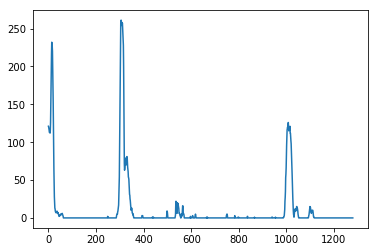

305
1008
window 0 leftx_current 308
window 1 leftx_current 309
window 1 rightx_current 1007
window 2 leftx_current 311
window 2 rightx_current 1013
window 3 leftx_current 315
window 4 leftx_current 326
window 4 rightx_current 1031
window 5 leftx_current 325
window 6 leftx_current 336
window 6 rightx_current 1044
window 7 leftx_current 338
window 7 rightx_current 1056
window 8 leftx_current 316
window 8 rightx_current 1067


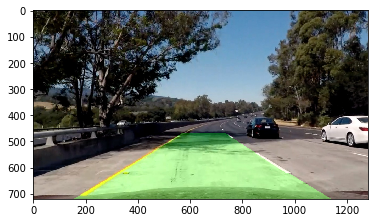

In [8]:
def warp_lane(binary_warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result
    

# Test function warp_lane()    
leftx, lefty, rightx, righty, left_fit, right_fit = sliding_window_fit(binary_warped)

result = warp_lane(binary_warped, undist_img, left_fitx, right_fitx, ploty)

plt.imshow(result)

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

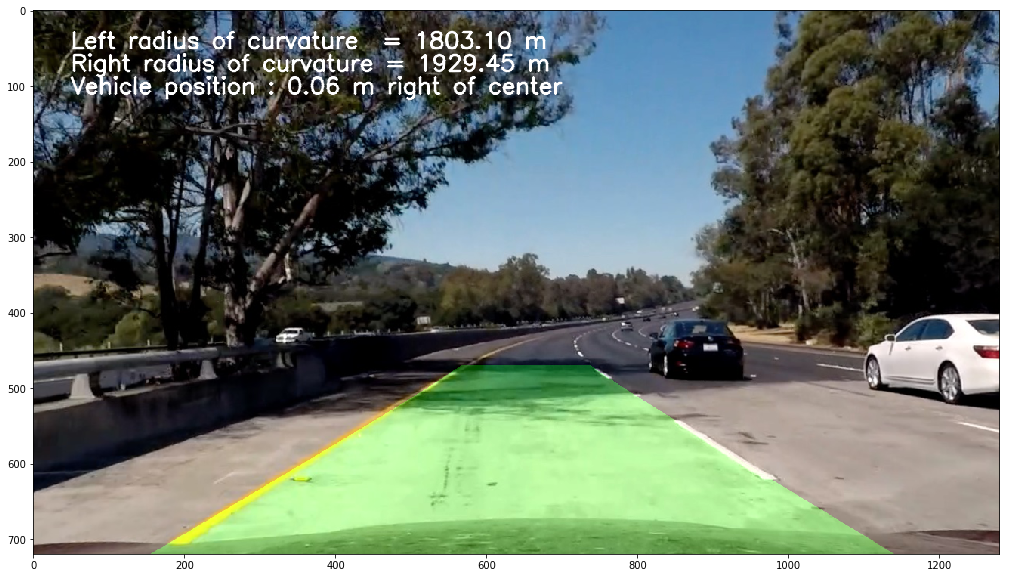

In [9]:
def put_text(result, left_curverad, right_curverad, offset):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_curverad,),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_curverad),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(offset), 'left' if offset < 0 else 'right'),(50,110), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result

put_text(result, left_curverad, right_curverad, offset)
plt.figure(figsize=(20,10))
plt.imshow(result)